### Module 16: Learning Notebook #2: More PCA

Let's try it with a "wider" dataset.

In [2]:
# Load libraries
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the data
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(data = cancer.data, columns = cancer.feature_names)
print('Dataset size:', df.shape)
df.head(2)

Dataset size: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


### Correlation matrix
Many features highly correlated

In [4]:
corr_df = df.corr()
corr_df.style.background_gradient(cmap='coolwarm').format(precision=2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.00,0.32,1.00,0.99,0.17,0.51,0.68,0.82,0.15,-0.31,0.68,-0.10,0.67,0.74,-0.22,0.21,0.19,0.38,-0.10,-0.04,0.97,0.30,0.97,0.94,0.12,0.41,0.53,0.74,0.16,0.01
mean texture,0.32,1.00,0.33,0.32,-0.02,0.24,0.30,0.29,0.07,-0.08,0.28,0.39,0.28,0.26,0.01,0.19,0.14,0.16,0.01,0.05,0.35,0.91,0.36,0.34,0.08,0.28,0.30,0.30,0.11,0.12
mean perimeter,1.00,0.33,1.00,0.99,0.21,0.56,0.72,0.85,0.18,-0.26,0.69,-0.09,0.69,0.74,-0.20,0.25,0.23,0.41,-0.08,-0.01,0.97,0.30,0.97,0.94,0.15,0.46,0.56,0.77,0.19,0.05
mean area,0.99,0.32,0.99,1.00,0.18,0.50,0.69,0.82,0.15,-0.28,0.73,-0.07,0.73,0.80,-0.17,0.21,0.21,0.37,-0.07,-0.02,0.96,0.29,0.96,0.96,0.12,0.39,0.51,0.72,0.14,0.00
mean smoothness,0.17,-0.02,0.21,0.18,1.00,0.66,0.52,0.55,0.56,0.58,0.30,0.07,0.30,0.25,0.33,0.32,0.25,0.38,0.20,0.28,0.21,0.04,0.24,0.21,0.81,0.47,0.43,0.50,0.39,0.50
mean compactness,0.51,0.24,0.56,0.50,0.66,1.00,0.88,0.83,0.60,0.57,0.50,0.05,0.55,0.46,0.14,0.74,0.57,0.64,0.23,0.51,0.54,0.25,0.59,0.51,0.57,0.87,0.82,0.82,0.51,0.69
mean concavity,0.68,0.30,0.72,0.69,0.52,0.88,1.00,0.92,0.50,0.34,0.63,0.08,0.66,0.62,0.10,0.67,0.69,0.68,0.18,0.45,0.69,0.30,0.73,0.68,0.45,0.75,0.88,0.86,0.41,0.51
mean concave points,0.82,0.29,0.85,0.82,0.55,0.83,0.92,1.00,0.46,0.17,0.70,0.02,0.71,0.69,0.03,0.49,0.44,0.62,0.10,0.26,0.83,0.29,0.86,0.81,0.45,0.67,0.75,0.91,0.38,0.37
mean symmetry,0.15,0.07,0.18,0.15,0.56,0.60,0.50,0.46,1.00,0.48,0.30,0.13,0.31,0.22,0.19,0.42,0.34,0.39,0.45,0.33,0.19,0.09,0.22,0.18,0.43,0.47,0.43,0.43,0.70,0.44
mean fractal dimension,-0.31,-0.08,-0.26,-0.28,0.58,0.57,0.34,0.17,0.48,1.00,0.00,0.16,0.04,-0.09,0.40,0.56,0.45,0.34,0.35,0.69,-0.25,-0.05,-0.21,-0.23,0.50,0.46,0.35,0.18,0.33,0.77


### PCA

In [5]:
# We are now only focused on the feature matrix:
X = df
X.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


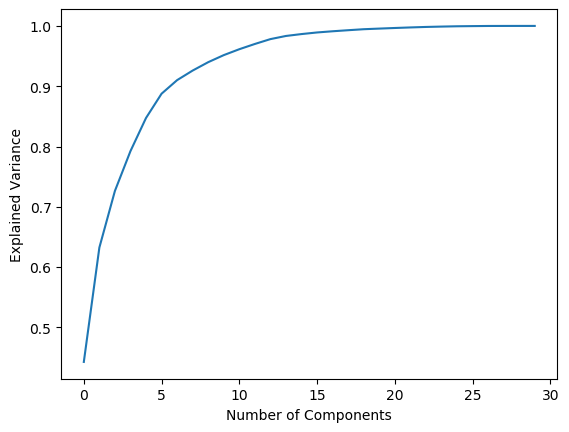

In [6]:
# Setup a scaler-PCA pipeline
#
scaler = StandardScaler() # Standardize the data
# Create a PCA model
pca = PCA(n_components = 30,random_state = 11) # first, let' use all features
#
steps = [('Scaler', scaler), ('PCA', pca)]
# Create a pipeline
pipe = Pipeline(steps)
# Fit
pipe.fit(X)
# Transform
principle_array = pipe.transform(X)
# Build a df
principal_df = pd.DataFrame(data = principle_array)
#
# Show the captured variance curve
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

### How many Principal Components to capture 90% of the variance?
- Set the n_components to the minimum % you want

In [7]:
# Capture 90%
# Setup a scaler-PCA pipeline
#
scaler = StandardScaler() # Standardize the data
# Create a PCA model
# Specify the percent of variance you want to capture
pca = PCA(n_components = 0.9,random_state = 11) # make sure we discuss n_componets = .9
#
steps = [('Scaler', scaler), ('PCA', pca)]
# Create a pipeline
pipe = Pipeline(steps)
# Fit
pipe.fit(X)
# Transform
principle_array = pipe.transform(X)
# Build a df
pca_90_df = pd.DataFrame(data = principle_array)
# Reduced to 7 features
print('Shape of new feature matrix:', pca_90_df.shape)
print('We captured this percent of variance:', round(sum(pca.explained_variance_ratio_),3))

Shape of new feature matrix: (569, 7)
We captured this percent of variance: 0.91


### Perform machine learning process on reduced dataset
- This will be a classification problem: 0 - didn't have cancer, 1 - did have cancer

In [8]:
# Load the target for the cancer data into a dataframe
target_df = pd.DataFrame(data = cancer.target, columns = ['cancer'])
target_df.value_counts()

cancer
1         357
0         212
dtype: int64

In [9]:
# Features
X = pca_90_df # Our reduced dataset, 7 features
# Target: Did the patient have cancer?
y = target_df['cancer'] # Create a series
# Split into train/test
# Reserve 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 42)
# Verify the sizes of the split datasets
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (455, 7)
y_train: (455,)
X_test: (114, 7)
y_test: (114,)


### Use a pipeline to evalute multiple algorithms
Using the new reduced dataset of 7 features (7 principal components), evaluate:
- Logistic Regression Classifier
- Gradient Boosting Classifier
- Suport Vector Machines

In [13]:
# Trying to predict 71 cases of cancer
y_test.value_counts()

1    71
0    43
Name: cancer, dtype: int64

In [14]:
# Logitic Regression
lr = LogisticRegression()
steps = [('Scaler', scaler), ('LogReg', lr)]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = lr.score(X_test, y_test) # Number predicted correctly divided by total in data set
print('Our model accuracy:', round(acc,4))
confusion_matrix(y_test, y_pred, labels = [1,0])

Our model accuracy: 0.9825


array([[70,  1],
       [ 2, 41]])

In [15]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
steps = [('Scaler', scaler), ('GBC', gbc)]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = gbc.score(X_test, y_test)
print('Our model accuracy:', round(acc,4))
confusion_matrix(y_test, y_pred, labels = [1,0])

Our model accuracy: 0.9386


array([[68,  3],
       [ 2, 41]])

In [16]:
svmc = svm.SVC() # SVM classifier
steps = [('Scaler', scaler), ('SVM', svmc)]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = svmc.score(X_test, y_test) # Number predicted correctly divided by total in data set
print('Our model accuracy:', round(acc,4))
confusion_matrix(y_test, y_pred, labels = [1,0])

Our model accuracy: 0.9211


array([[68,  3],
       [ 4, 39]])